### Volume analysis through Nup133 labeling
Script that aims to analyze cell microscopy data in order to gain insight into cell volume dynamics. In this case, since there's only GFP channel data, we investigate what thresholding method is best at filtering out the nuclear surface. The nuclear volume is calculated using the data that the best thresholding method generates. This is done for every frame of every cell.

Made by Olle de Jong, based on preexisting microscopy analysis files by Luc-Alban Vuillemenot.

In [70]:
""" Imports """
import os
import random
import re
from math import pi, sin, cos
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.ndimage import binary_erosion
from skimage.io import imread
from skimage.filters import threshold_local, threshold_minimum, threshold_multiotsu
from skimage.morphology import remove_small_objects, disk, erosion
import bottleneck as bn
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [3]:
""" Globals """
# globally define bottleneck 'nanmean' estimator
nan_mean = bn.nanmean

# IMPORTANT PATHS
# Data files
data_dir = "C:/Users/Olle de Jong/Documents/MSc Biology/MSB Research/Code and data/Data"
tiff_files_dir = data_dir + "/processed_tiffs_nup133/"  # relative path from data directory to tiff directory
output_dir = data_dir + "/Output/"  # relative path from data directory to image output directory
# Data sheets
budj_data_folder = data_dir + "/Other/Nup133/BudJ/"  # folder that holds the BudJ info on all cells
budding_data_path = data_dir + "/Other/Nup133/buddings.txt"  # budding events
kario_data_path = data_dir + "/Other/Nup133/kariokinesis.txt"  # kariokinesis events

# thresholding globals
scaling_factor = 0.16  # microns per pixel ---> 100x objective
bloc_size_frac_to_use = 0.09
offset_to_use = -50

Now we define a couple of functions that will be used throughout the analysis process. There's a function for time conversion from 'frame' time to real time, since one frame is equal to 5 real time minutes. For function descriptions, see the function's docstring.

In [4]:
def ellipse_from_budj(t, cell_data, scaling_factor):
    """
    Define the function that can extract parameters of the ellipse using the data
    Function to extract parameters of the ellipse from the BudJ table
    """
    data_at_frame = cell_data[cell_data["TimeID"] == t]
    x_pos = float(data_at_frame['x']) / scaling_factor
    y_pos = float(data_at_frame['y']) / scaling_factor
    majorR = float(data_at_frame["Major R"]) / scaling_factor
    minorR = float(data_at_frame["Minor r"]) / scaling_factor
    angle = float(data_at_frame['Angle']) * (pi / 180)  # convert to radians
    return x_pos, y_pos, majorR, minorR, angle

def get_ellipse(imageRFP, nuc_mask):
    """
    Function that generates and fits the ellipse using the opencv package. It takes a nuclear mask as argument.
    """
    mask = imageRFP * nuc_mask
    thresh = mask.astype(np.uint8)  # change type to uint8

    contours, hierarchy = cv2.findContours(thresh, 1, 2)

    # if there is a contour found
    if len(contours) > 0:
        cnt = max(contours,key=len)
        if len(cnt) > 4:
            return cv2.fitEllipse(cnt)

def round_up_to_odd(f):
    """
    Rounds up any number to a whole odd integer
    """
    return int(np.ceil(f) // 2 * 2 + 1)

def plot_from_list(fig_title, data_list, xlim, ylim, save_fig=False, filename="test.png"):
    """
    Given a dictionary that holds image plot titles and data, plot those in one figure.
    """
    if save_fig:
        plt.ioff()
    fig = plt.figure(figsize=(3.6 * len(data_list), 4.1), edgecolor="black", frameon=True, facecolor="white", layout="tight").suptitle(fig_title, fontsize=14, y=1)
    i = 1
    for data in data_list:
        subplt = plt.subplot(1, len(data_list), i)
        subplt.set_title(label=data[0], y=1.02)
        plt.imshow(data[1], cmap=data[2])
        subplt.grid(False)
        plt.xlim(xlim)
        plt.ylim(ylim)
        i += 1
    if save_fig:
        plt.savefig(output_dir + filename, dpi=350)
    else:
        plt.show()

To keep track of not only the frame that we are looking at, but also how many real time minutes have passed, we convert the TimeIDs column to a real time column (minutes) and add this to the dataframe later.

In [5]:
TimeIDs = 150 # maximum amount of timepoints for a single cell
time_step = 5 # every time-point equals 5 real time minutes

TimeIDs = range(1, TimeIDs + 1) # TimeIDs range 1 through 150
TimeMins = [x * 5 for x in TimeIDs] # convert to minutes

time_conversion = pd.DataFrame({"TimeID" : TimeIDs, "Time" : TimeMins})

Now that we've loaded some handy functions, we can proceed with loading the BudJ data. One file contains the information for one position which include one through three/four individual cells.

In [6]:
# find all the files that hold budj data
files = []
for filename in os.listdir(budj_data_folder):
    if ".csv" in filename:
        prefix_position = f"pos{filename[-25:-23]}_"
        files.append((filename, prefix_position))

# add the data of all files to one single dataframe
budj_data = pd.DataFrame({})
for f in files:
    pos_data = pd.read_csv(budj_data_folder+ f[0], header=0, index_col=0)
    pos_data["Cell_pos"] = f[1] + pos_data["Cell"].map(str)
    pos_data = pos_data.loc[:, ["TimeID", "Cell_pos", "Volume", "x", "y", "Major R", "Minor r", "Angle"]]
    budj_data = pd.concat([budj_data, pos_data])

budj_data = pd.merge(budj_data, time_conversion, on="TimeID")
budj_data = budj_data.sort_values(["Cell_pos", "TimeID"])

individual_cells = sorted(list(set(budj_data["Cell_pos"])))
print(f"There are {len(individual_cells)} cells in the final dataframe.")

There are 50 cells in the final dataframe.


Now, lets load the budding and karyoginesis event timepoints from the by BudJ produced files.

In [38]:
events_files = {"budding": budding_data_path, "kariokinesis": kario_data_path}

budding_events = {}
kario_events = {}
for event_type in events_files:  # for either budding or kariokinesis events
    opened_file = open(events_files[event_type])  # open the file
    events = {}  # temp storage object
    for line in opened_file:  # every line in the file is a cell
        if line == "\n":
            continue
        # process the two parts of the line by removing characters
        parts = line.split(':')
        cell_id = parts[0].replace("\"", "").strip()  # first part of the line is the individual cell
        timepoints = re.sub('[\[\]]', "", parts[1])  # second part are the timepoints
        # split timepoints on space to capture them in a list
        split_timepoints = timepoints.split(",")
        events[cell_id] = [int(x.strip()) for x in split_timepoints[:-1]] # remove redundant last comma

    # save the events to the right dictionary
    if event_type == "budding":
        budding_events = events
    if event_type == "kariokinesis":
        kario_events = events
    opened_file.close()

print(f"There are budding events for {len(budding_events)} cells")
print(f"There are karyokinesis events for {len(kario_events)} cells")

There are budding events for 50 cells
There are karyokinesis events for 50 cells


Lets also define a function, since it will be used multiple times, for getting the whole cell mask based on the BudJ data.

In [192]:
def get_whole_cell_mask(t, single_cell_data, image_shape):
    # get/calculate the ellipse information
    x_pos, y_pos, majorR, minorR, A = ellipse_from_budj(t, single_cell_data, scaling_factor)

    y_dim, x_dim = image_shape  # get the dimensions (512x512)

    # create an ogrid that helps us select/'mask' the info we want
    row, col = np.ogrid[:y_dim, :x_dim]

    # get the mask of the whole cell
    return (
            (
                (((col - x_pos) * cos(A) + (row - y_pos) * sin(A)) ** 2) / (majorR ** 2)
                 +
                (((col - x_pos) * sin(A) - (row - y_pos) * cos(A)) ** 2) / (minorR ** 2) - 1
            ) # if this sum
            < 0  # is smaller than zero
    ), x_pos, y_pos

### Whole cell masking using BudJ data
Using the whole-cell mask, we can filter out the pixel/image data that belongs to a specific cell.

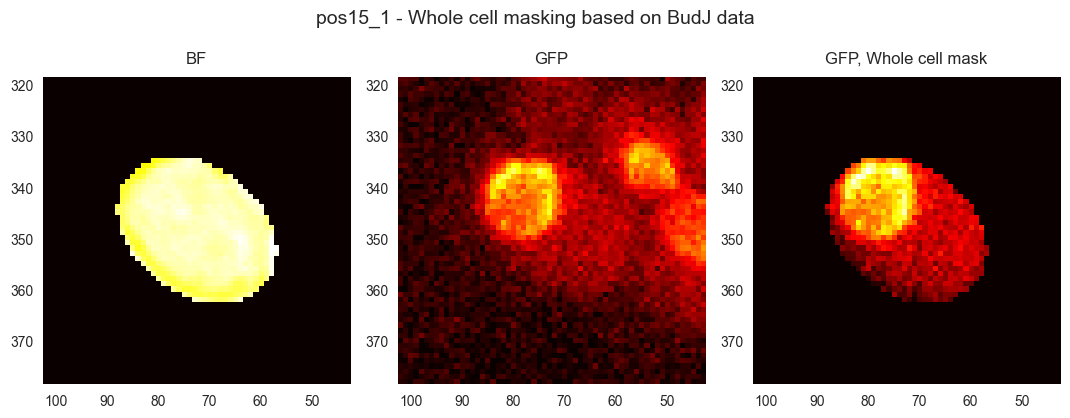

In [18]:
# let's test this on one particular cell
pos = "15"
cell_pos = "pos15_1"

# This image variable is a 4 dimensional array. The outer array of 150 length holds matrices of
# 512 by 512 pixels. These each hold 2 values. Index 0: BF channel, index 1: GFP channel
image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif"))

# let's take cell 2 of position 01 as example
cell = 1

# get the data for the single cell
single_cell_data = budj_data[budj_data["Cell_pos"] == cell_pos]

t = 30
t_in_tiff = t - 1  # skew the time by one

imageBF = image[t_in_tiff, 0, :, :]
imageGFP = image[t_in_tiff, 1, :, :]

# get the whole cell mask
whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP.shape)

# plot the regular BF and GFP channels and compare this to the masked whole cell (based on ImageJ data)
to_plot = [
    ["BF", imageBF * whole_cell_mask, "hot"],
    ["GFP", imageGFP, "hot"],
    ["GFP, Whole cell mask",  imageGFP * whole_cell_mask, "hot"]
]
plot_from_list(f"{cell_pos} - Whole cell masking based on BudJ data", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30), False)

### Different thresholding methods
Here we compare multiple thresholding methodologies. This is done on multiple randomly chosen cells. Local thresholding generates a threshold mask image based on local pixel neighborhood. The algorithm behind Otsu thresholding searches for the threshold that minimizes the intra-class variance to essentially split the pixels into two or multiple classes.
#### Multi-otsu thresholding on whole GFP channel
Multi-otsu thresholding is powerfull when applied to a whole image. Based on all data, the algorithm separates the pixel intensities into the desired amount of classes. We use the max here, which is 5 classes. The most intense pixel class would ideally only be our nuclei.

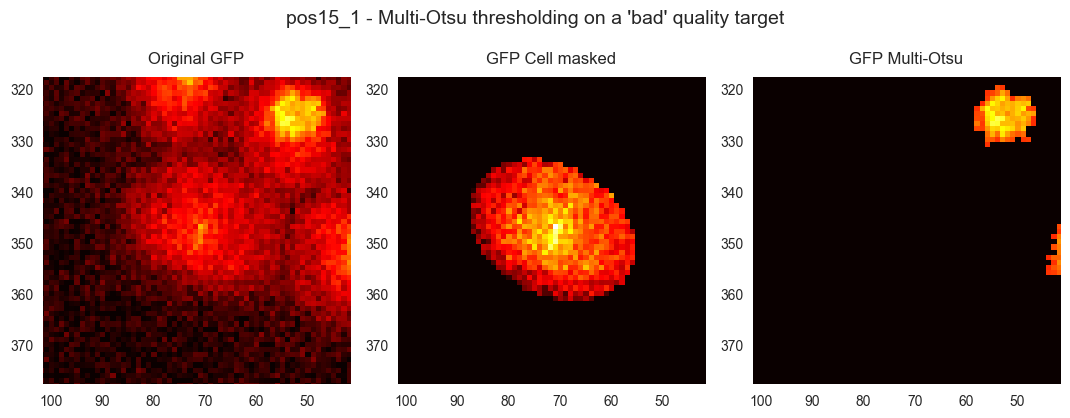

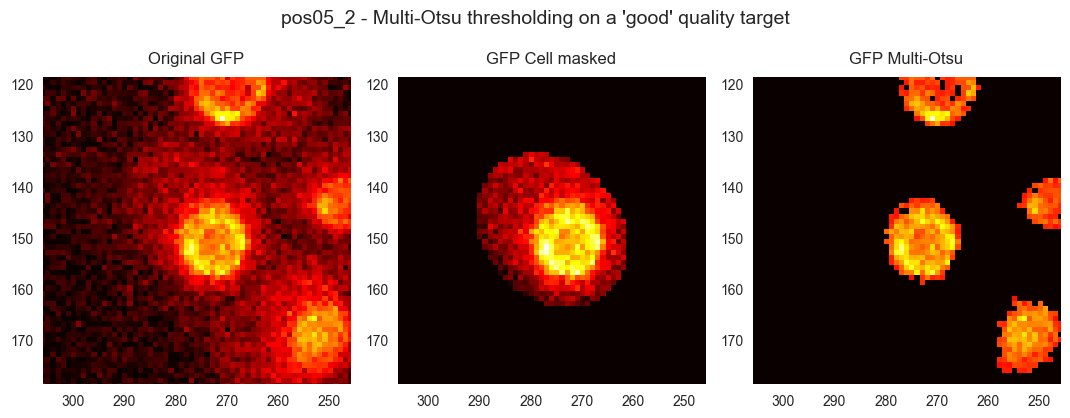

In [19]:
cells = ["pos15_1", "pos05_2"]
for cell in cells:
    img = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{cell[3:5]}.nd2.tif"))
    t = 34
    t_in_tiff = t - 1
    imageGFP = img[t_in_tiff, 1, :, :]

    single_cell_data = budj_data[budj_data["Cell_pos"] == cell]
    whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP.shape)

    thresholds = threshold_multiotsu(imageGFP, classes=5)  # perform multi-otsu thresholding on whole image
    regions = np.digitize(imageGFP, bins=thresholds)
    mlti_otsu_thresh = thresholds[-1]
    mask_mlti_otsu = remove_small_objects(imageGFP > mlti_otsu_thresh)

    to_plot = [
        ["Original GFP", imageGFP, "hot"],
        ["GFP Cell masked", imageGFP * whole_cell_mask, "hot"],
        ["GFP Multi-Otsu", imageGFP * mask_mlti_otsu, "hot"]
    ]
    plot_from_list(f"{cell} - Multi-Otsu thresholding on a '{'bad' if cell == 'pos15_1' else 'good'}' quality target", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30))

As you can tell, for cell 'pos15_1', the nucleus is so poorly captured that it does not fall within the 'nuclei class'. On the other hand, for 'pos05_1', when the nucleus is captured well (which you can tell by eye), the multi-otsu thresholding seems to be spot on. However, the hypothesis is that this method might result in the loss of quite some data, since it might not always be able to find nuclear pixels at all.

#### Local thresholding
Let's perform another type of thresholding on the very same cells.

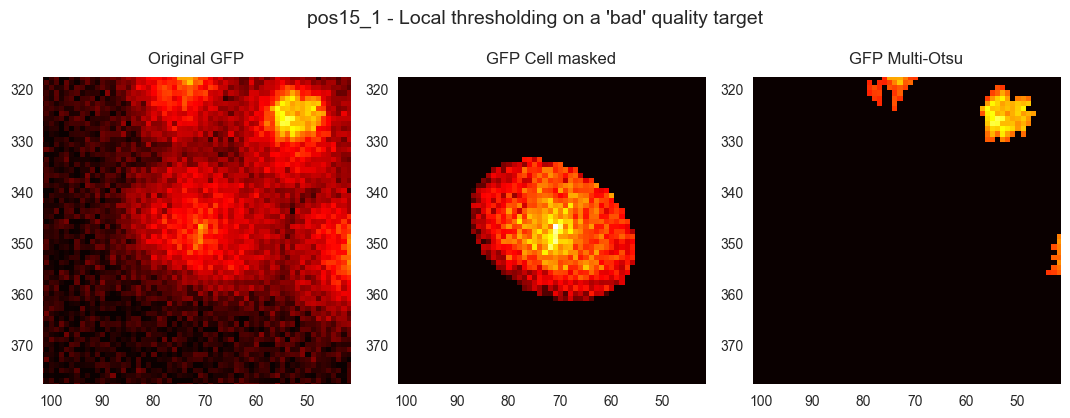

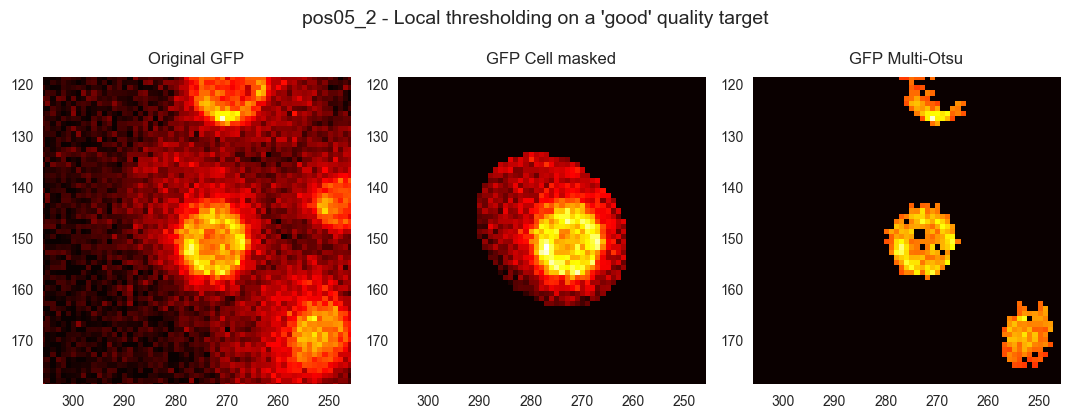

In [20]:
cells = ["pos15_1", "pos05_2"]
for cell in cells:
    img = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{cell[3:5]}.nd2.tif"))
    t = 34
    t_in_tiff = t - 1
    imageGFP = img[t_in_tiff, 1, :, :]

    single_cell_data = budj_data[budj_data["Cell_pos"] == cell]
    whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP.shape)

    num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
    bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)
    nucl_thresh_mask_local = threshold_local(image=imageGFP, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)
    imageGFP_nuc_mask_local = remove_small_objects(imageGFP > nucl_thresh_mask_local)

    to_plot = [
        ["Original GFP", imageGFP, "hot"],
        ["GFP Cell masked", imageGFP * whole_cell_mask, "hot"],
        ["GFP Multi-Otsu", imageGFP * imageGFP_nuc_mask_local, "hot"]
    ]
    plot_from_list(f"{cell} - Local thresholding on a '{'bad' if cell == 'pos15_1' else 'good'}' quality target", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30))

#### Comparing multiple thresholding methods
Before we investigate the effect of brightness and contrast adjustments on thresholding performance, let's plot the outcomes of different thresholding methods side by side for a small sample of cells.

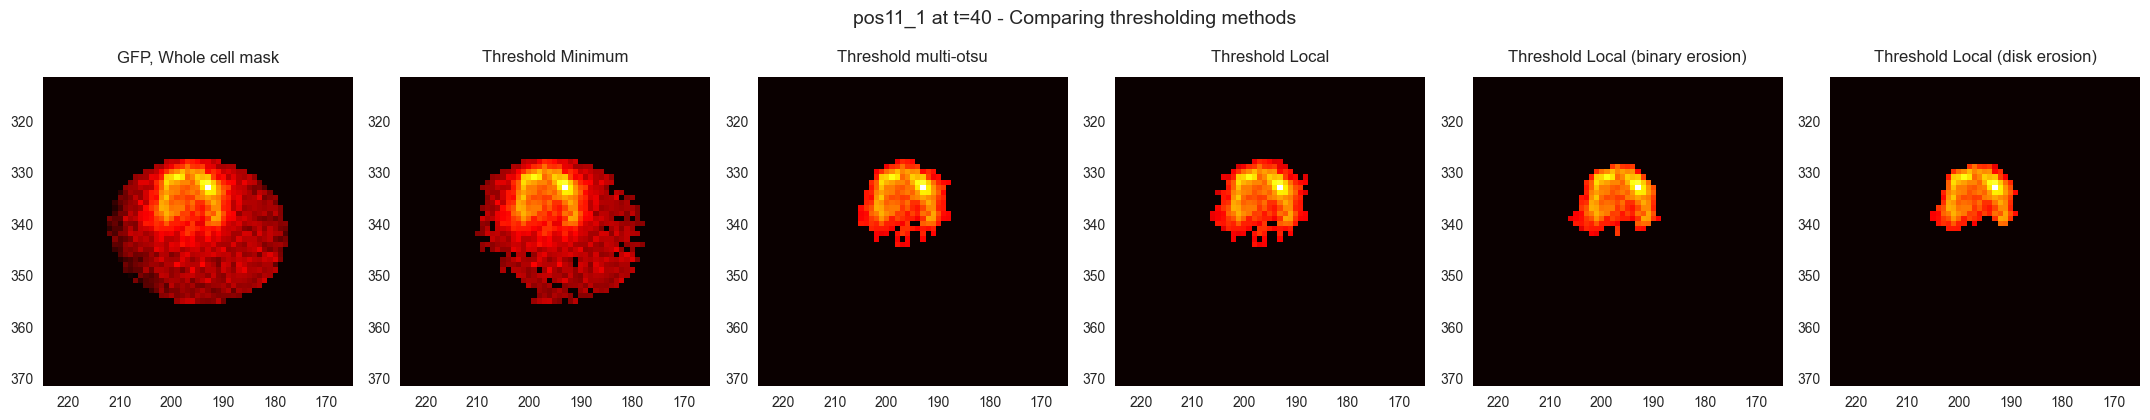

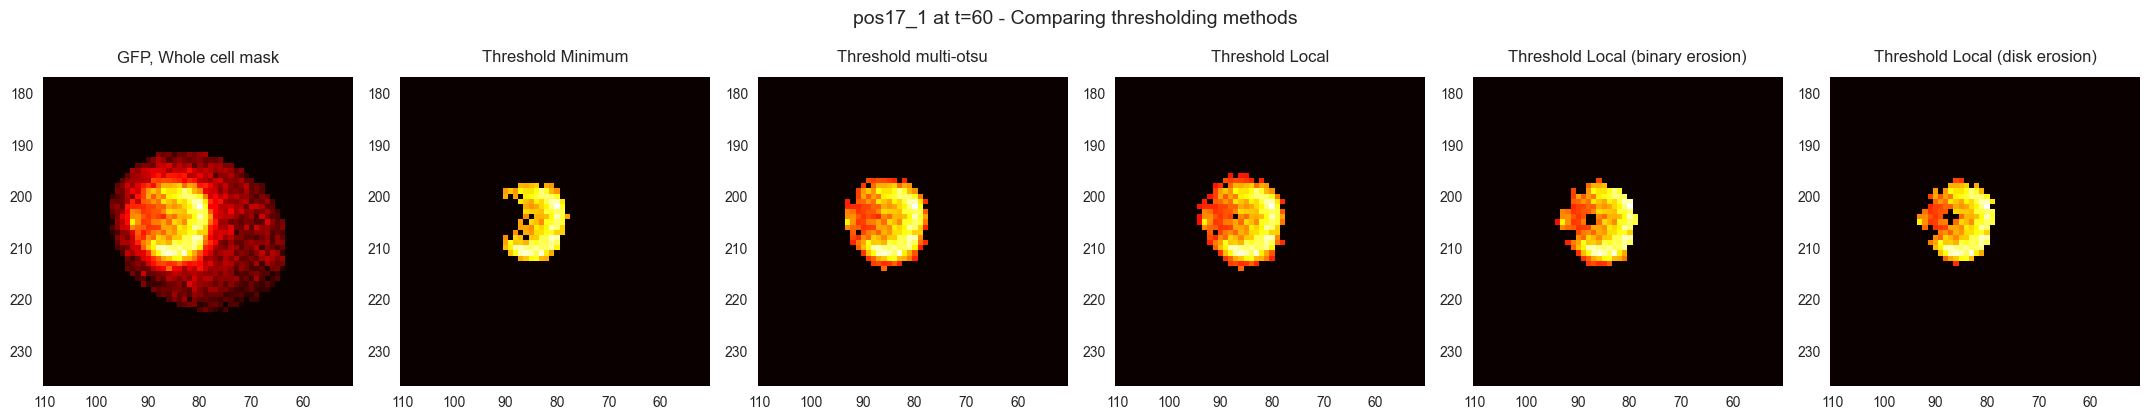

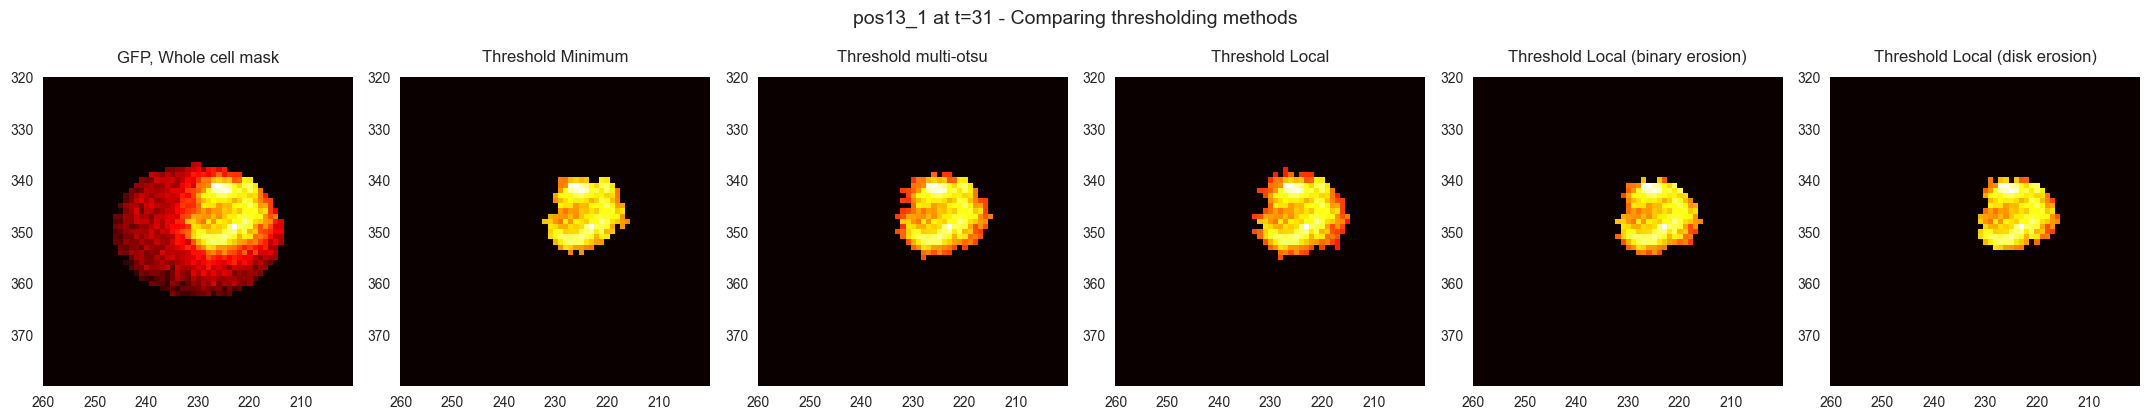

In [32]:
for cell in random.sample(individual_cells, 3):
    pos = cell[3:5]

    image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif")) # load the image
    single_cell_data = budj_data[budj_data["Cell_pos"] == cell]  # get the data for the single cell

    # get the first available frame
    t_first = single_cell_data['TimeID'].iloc[0]
    t_last = single_cell_data['TimeID'].iloc[-1]
    t = random.sample(range(t_first, t_last), 1)[0]
    t_in_tiff = t - 1

    imageBF = image[t_in_tiff, 0, :, :]
    imageGFP = image[t_in_tiff, 1, :, :]

    whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP.shape)

                        # PERFORM DIFFERENT THRESHOLD METHODS
    num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
    bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

    # adaptive thresholding will be performed not on all image but on a fraction of it which includes the cell
    imageGFP_cell_mask = imageGFP * whole_cell_mask  # keep the part of the GFP channel that is within the cell mask

    # thresholding for getting the nuclear mask
    nucl_thresh_mask_local = threshold_local(  # local thresholding
        image=imageGFP_cell_mask,
        block_size=bloc_size_cell_size_dependent,
        method='gaussian',
        offset=offset_to_use,
        mode='reflect'
    )
    nucl_thresh_mask_minimum = threshold_minimum(imageGFP_cell_mask)  # perform minimum thresholding
    thresholds = threshold_multiotsu(imageGFP, classes=5)  # perform multi-otsu thresholding on whole image
    nucl_thresh_mask_mlti_otsu = thresholds[-1]

    # keep the nucleus pixels that are greater than the local threshold (either with or without erosion)
    imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
    imageGFP_nuc_mask_minimum = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_minimum)
    imageGFP_nuc_mask_mlti_otsu = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_mlti_otsu)

    imageGFP_nuc_mask_local_eroded_binary = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))
    imageGFP_nuc_mask_local_eroded_binary = remove_small_objects(imageGFP_nuc_mask_local_eroded_binary)
    imageGFP_nuc_mask_local_eroded_disk = erosion(imageGFP_nuc_mask_local, disk(1))
    imageGFP_nuc_mask_local_eroded_disk = remove_small_objects(imageGFP_nuc_mask_local_eroded_disk)
    # imageGFP_nuc_mask_mlti_otsu_eroded = binary_erosion(imageGFP_nuc_mask_mlti_otsu, structure = np.ones((2,2)))
    # imageGFP_nuc_mask_mlti_otsu_eroded = remove_small_objects(imageGFP_nuc_mask_mlti_otsu_eroded)

    to_plot = [
        ["GFP, Whole cell mask",  imageGFP * whole_cell_mask, "hot"],
        ["Threshold Minimum", imageGFP * imageGFP_nuc_mask_minimum, "hot"],
        ["Threshold multi-otsu", imageGFP * imageGFP_nuc_mask_mlti_otsu, "hot"],
        ["Threshold Local", imageGFP * imageGFP_nuc_mask_local, "hot"],
        ["Threshold Local (binary erosion)", imageGFP * imageGFP_nuc_mask_local_eroded_binary, "hot"],
        ["Threshold Local (disk erosion)", imageGFP * imageGFP_nuc_mask_local_eroded_disk, "hot"]
    ]

    plot_from_list(f"{cell} at t={t} - Comparing thresholding methods", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30))

Local thresholding, and multi-otsu thresholding seem to extract the nucleus most accurately. Minimum thresholding is also performing well, but as you can tell, when the nuclear intensity is not sufficiently high, the minimum method does not result in the desired result at all. In this case, it seems unreliable because of its all-or-nothing nature. Once the piece of investigative code above is run a couple of times, we find that thresholding with erosion performs best.

#### Different Local Threshold settings

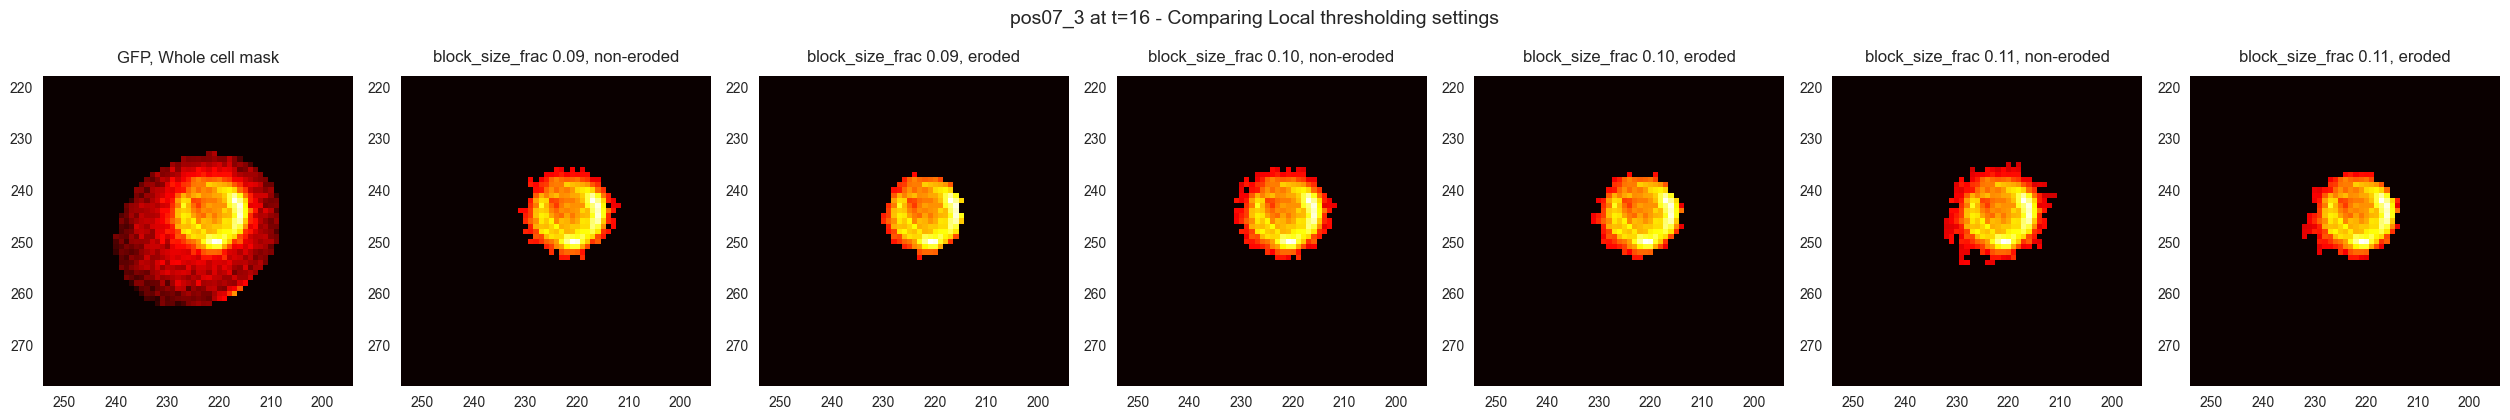

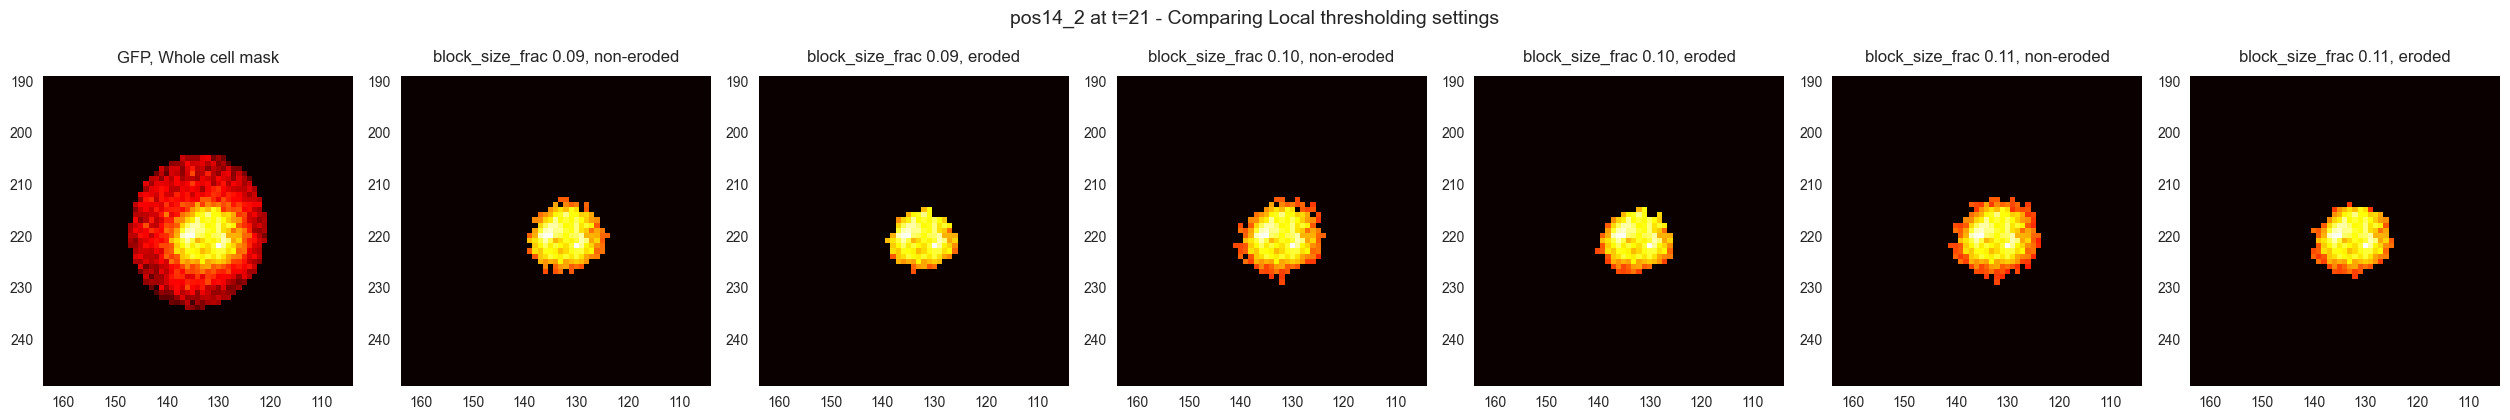

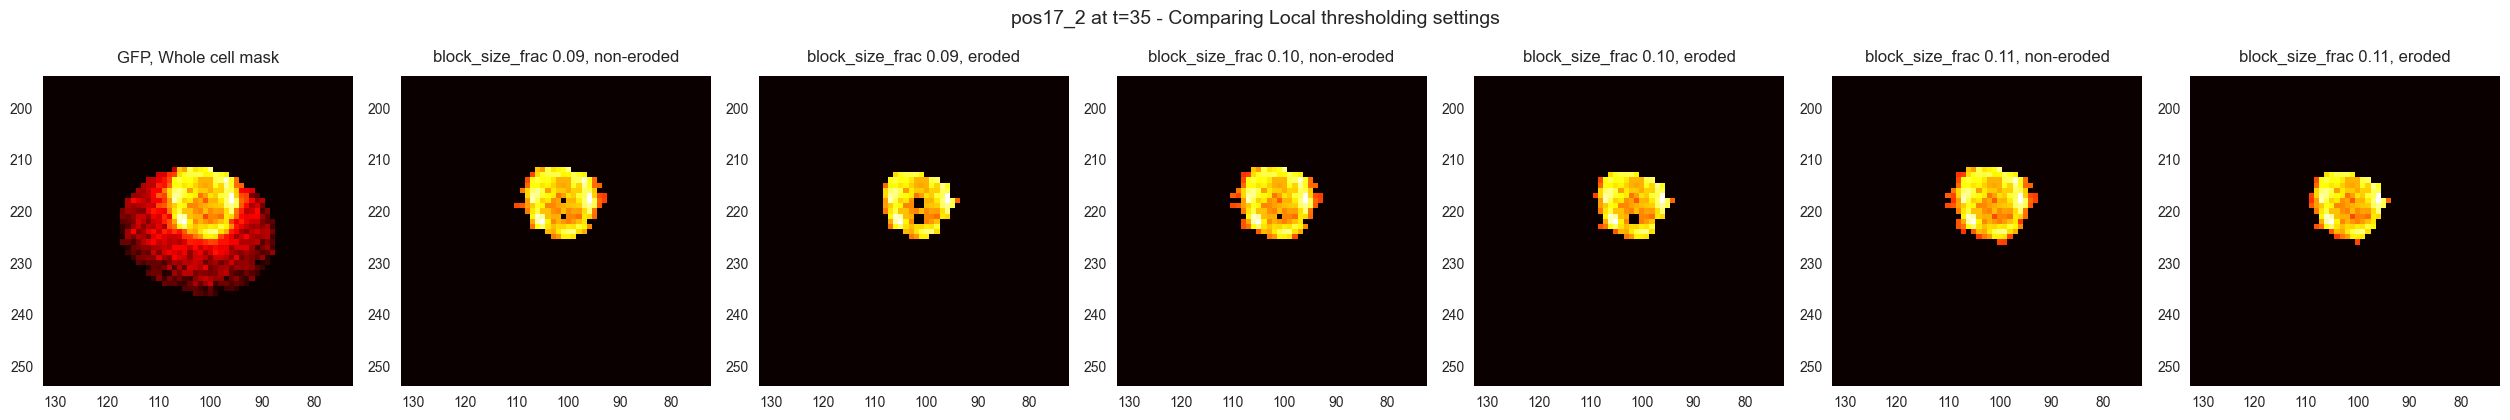

In [36]:
for cell in random.sample(individual_cells, 3):
    pos = cell[3:5]

    image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif")) # load the image
    single_cell_data = budj_data[budj_data["Cell_pos"] == cell]  # get the data for the single cell

    # get the first available frame
    t_first = single_cell_data['TimeID'].iloc[0]
    t_last = single_cell_data['TimeID'].iloc[-1]
    t = random.sample(range(t_first, t_last), 1)[0]
    t_in_tiff = t - 1

    imageBF = image[t_in_tiff, 0, :, :]
    imageGFP = image[t_in_tiff, 1, :, :]
    whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP.shape)

                        # PERFORM DIFFERENT THRESHOLD METHODS
    num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
    bloc_size_cell_size_dependent = round_up_to_odd(0.09 * num_cell_pixels)
    bloc_size_cell_size_dependent2 = round_up_to_odd(0.10 * num_cell_pixels)
    bloc_size_cell_size_dependent3 = round_up_to_odd(0.11 * num_cell_pixels)

    # thresholding will be performed not on all image but on a fraction of it which includes the cell
    imageGFP_cell_mask = imageGFP * whole_cell_mask

    # thresholding to get the nuclear mask
    nucl_thresh_mask_local = threshold_local(image=imageGFP_cell_mask, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)
    nucl_thresh_mask_local2 = threshold_local(image=imageGFP_cell_mask, block_size=bloc_size_cell_size_dependent2, offset=offset_to_use)
    nucl_thresh_mask_local3 = threshold_local(image=imageGFP_cell_mask, block_size=bloc_size_cell_size_dependent3, offset=offset_to_use)

    # keep the pixels that are greater than the threshold
    imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
    imageGFP_nuc_mask_local2 = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local2)
    imageGFP_nuc_mask_local3 = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local3)

    # apply erosion
    imageGFP_nuc_mask_local_eroded = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))
    imageGFP_nuc_mask_local_eroded2 = binary_erosion(imageGFP_nuc_mask_local2, structure = np.ones((2,2)))
    imageGFP_nuc_mask_local_eroded3 = binary_erosion(imageGFP_nuc_mask_local3, structure = np.ones((2,2)))

    to_plot = [
        ["GFP, Whole cell mask",  imageGFP * whole_cell_mask, "hot"],
        ["block_size_frac 0.09, non-eroded", imageGFP * imageGFP_nuc_mask_local, "hot"],
        ["block_size_frac 0.09, eroded", imageGFP * imageGFP_nuc_mask_local_eroded, "hot"],
        ["block_size_frac 0.10, non-eroded", imageGFP * imageGFP_nuc_mask_local2, "hot"],
        ["block_size_frac 0.10, eroded", imageGFP * imageGFP_nuc_mask_local_eroded2, "hot"],
        ["block_size_frac 0.11, non-eroded", imageGFP * imageGFP_nuc_mask_local3, "hot"],
        ["block_size_frac 0.11, eroded", imageGFP * imageGFP_nuc_mask_local_eroded3, "hot"]
    ]

    plot_from_list(f"{cell} at t={t} - Comparing Local thresholding settings", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30))

The block size is the size of the pixel neighbourhood that is used to calculate a threshold. In this example, it is based on the whole cell mask size. A block_size_frac of 0.09 (non-eroded), or a block_size_frac of 0.10 (eroded) seems to be the sweet spot.
### The effect of brightness/contrast adjustments on thresholding performance
#### Investigation of B&C adjustments

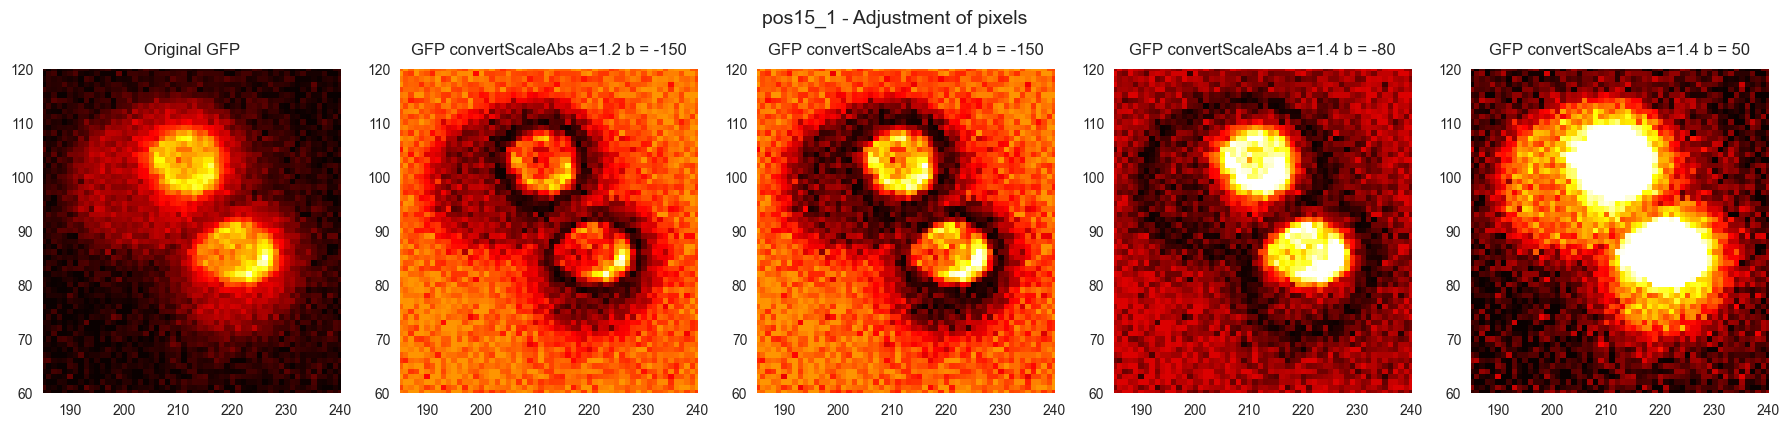

In [37]:
pos = "15"
cell_pos = "pos15_1"
image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif"))  # load the image

single_cell_data = budj_data[budj_data["Cell_pos"] == cell_pos]

t = 1
t_in_tiff = t - 1  # skew the time by one

imageGFP = image[t_in_tiff, 1, :, :]

new_image2 = cv2.convertScaleAbs(imageGFP, alpha=1.2, beta=-150)
new_image3 = cv2.convertScaleAbs(imageGFP, alpha=1.4, beta=-150)
new_image4 = cv2.convertScaleAbs(imageGFP, alpha=1.4, beta=-80)
new_image5 = cv2.convertScaleAbs(imageGFP, alpha=1.4, beta=50)

to_plot = [
    ["Original GFP", imageGFP, "hot"],
    ["GFP convertScaleAbs a=1.2 b = -150", new_image2, "hot"],
    ["GFP convertScaleAbs a=1.4 b = -150", new_image3, "hot"],
    ["GFP convertScaleAbs a=1.4 b = -80", new_image4, "hot"],
    ["GFP convertScaleAbs a=1.4 b = 50", new_image5, "hot"]
]
plot_from_list(f"{cell_pos} - Adjustment of pixels", to_plot, (185, 240), (60, 120), False, "testtest.png")

#### Brightness & Contrast adjustments on Multi-otsu Thresholding
Let's pick a few random cells to investigate on.

In [39]:
random_cells = random.sample(individual_cells, 2)
print(f"Randomly picked cells {random_cells} to perform thresholding on.")

Randomly picked cells ['pos07_2', 'pos20_1'] to perform thresholding on.


In [40]:
a = 1.2
b = -25

In [43]:
def get_eroded_multi_otsu_mask(image, erode = True, erode_intensity = 2):
    """
    Function that returns the nuclear eroded multi otsu threshold mask for a given image
    """
    thresholds = threshold_multiotsu(image, classes=5)  # perform multi-otsu thresholding on whole image
    mlti_otsu_thresh = thresholds[-1]
    imageGFP_nuc_mask_mlti_otsu = remove_small_objects(imageGFP > mlti_otsu_thresh)
    imageGFP_nuc_mask_mlti_otsu = imageGFP_nuc_mask_mlti_otsu * whole_cell_mask
    if not erode:
        return imageGFP_nuc_mask_mlti_otsu
    return binary_erosion(imageGFP_nuc_mask_mlti_otsu, structure = np.ones((erode_intensity, erode_intensity)))

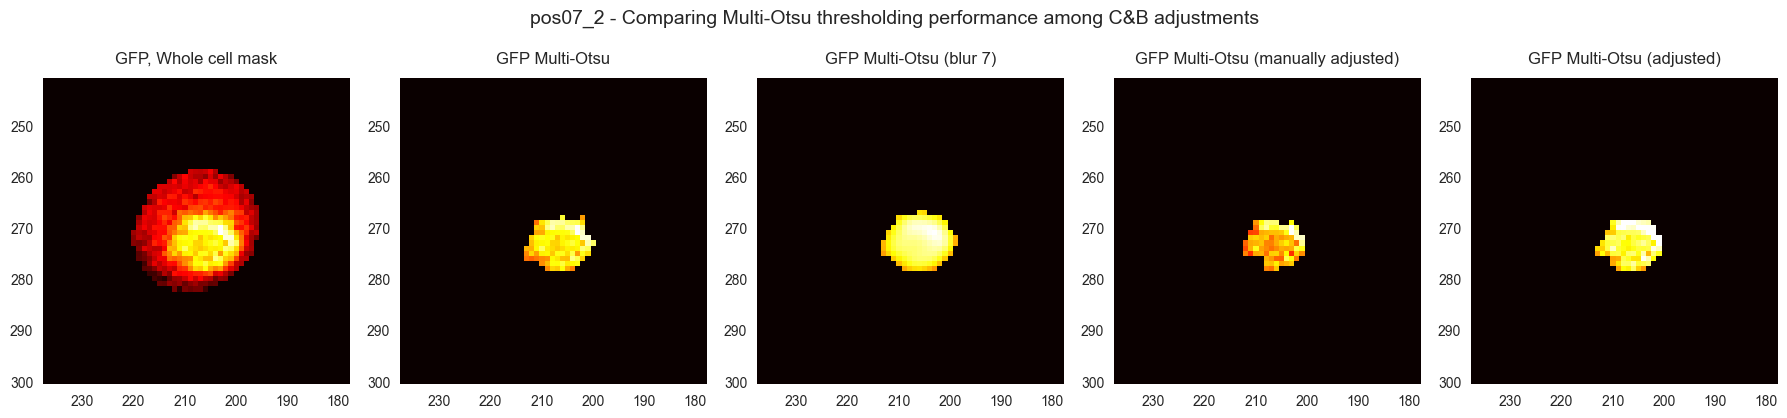

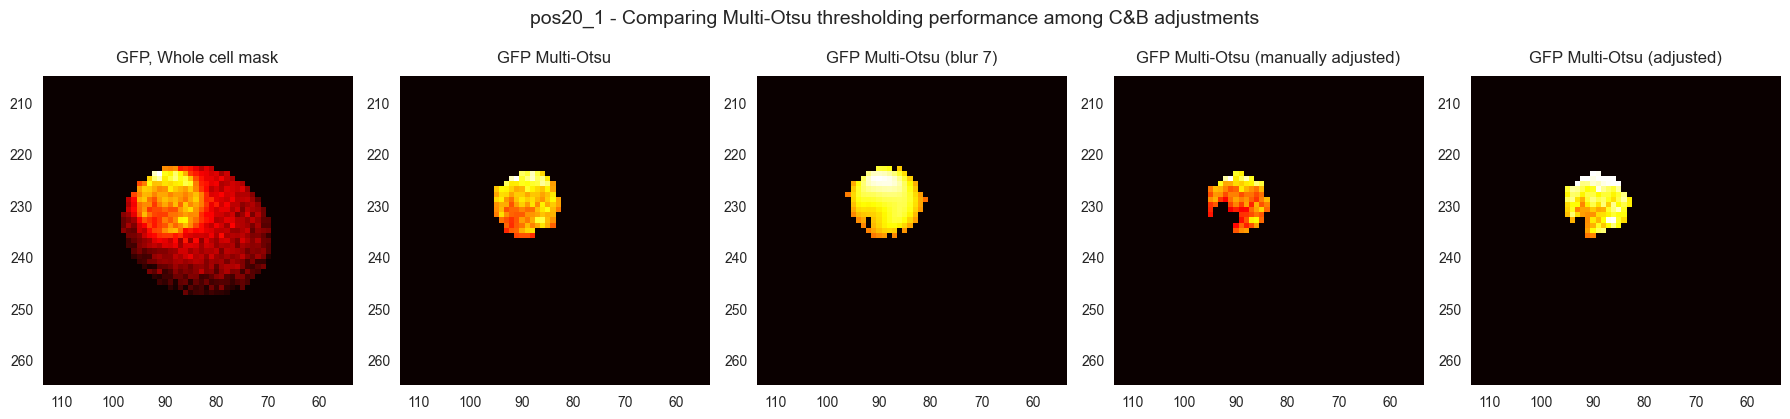

In [44]:
for cell in random_cells:
    image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{cell[3:5]}.nd2.tif")) # load the image
    single_cell_data = budj_data[budj_data["Cell_pos"] == cell]  # get the data for the single cell

    t = single_cell_data['TimeID'].iloc[0] # get the t of the first available frame
    t_in_tiff = t - 1 # time in table starts at 1, but time in image object starts at 0

    imageBF = image[t_in_tiff, 0, :, :]
    imageGFP = image[t_in_tiff, 1, :, :]
    imageGFP_blurred = cv2.GaussianBlur(imageGFP, (7,7), 0)
    new_imageGFP1 = cv2.convertScaleAbs(imageGFP, alpha=a, beta=b)
    # manually adjust image
    new_image = np.zeros(imageGFP.shape, imageGFP.dtype)
    adj = 75
    for i in range(imageGFP.shape[0]):
        for j in range(imageGFP.shape[1]):
            prev_val = imageGFP[i, j]
            if prev_val >= adj:
                new_image[i, j] = prev_val - adj
            else:
                new_image[i, j] = 0

    whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP.shape) # get the whole cell mask based on budj data

    # Perform multi-otsu for all images
    imageGFP_nuc_mask_mlti_otsu_eroded = get_eroded_multi_otsu_mask(imageGFP, True, 2) # original image
    imageGFP_nuc_mask_mlti_otsu_eroded_blurred = get_eroded_multi_otsu_mask(imageGFP_blurred, True, 1) # blurred image 7
    imageGFP_nuc_mask_mlti_otsu_eroded_man_adj = get_eroded_multi_otsu_mask(new_image, True, 2) # manually brightness reduction
    imageGFP_nuc_mask_mlti_otsu_eroded_adjusted = get_eroded_multi_otsu_mask(new_imageGFP1, True, 2) # Brightness and Contrast adjustment

    to_plot = [
        ["GFP, Whole cell mask",  imageGFP * whole_cell_mask, "hot"],
        ["GFP Multi-Otsu", imageGFP * imageGFP_nuc_mask_mlti_otsu_eroded, "hot"],
        ["GFP Multi-Otsu (blur 7)", imageGFP_blurred * imageGFP_nuc_mask_mlti_otsu_eroded_blurred, "hot"],
        ["GFP Multi-Otsu (manually adjusted)", new_image * imageGFP_nuc_mask_mlti_otsu_eroded_man_adj, "hot"],
        ["GFP Multi-Otsu (adjusted)", new_imageGFP1 * imageGFP_nuc_mask_mlti_otsu_eroded_adjusted, "hot"]
    ]
    plot_from_list(f"{cell} - Comparing Multi-Otsu thresholding performance among C&B adjustments", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30))

#### Fitting the nuclear ellipse
Using the get_ellipse function, we now plot the original RFP channel, the thresholding result, and the fitted ellipse all in one figure to provide an overview of the performance.

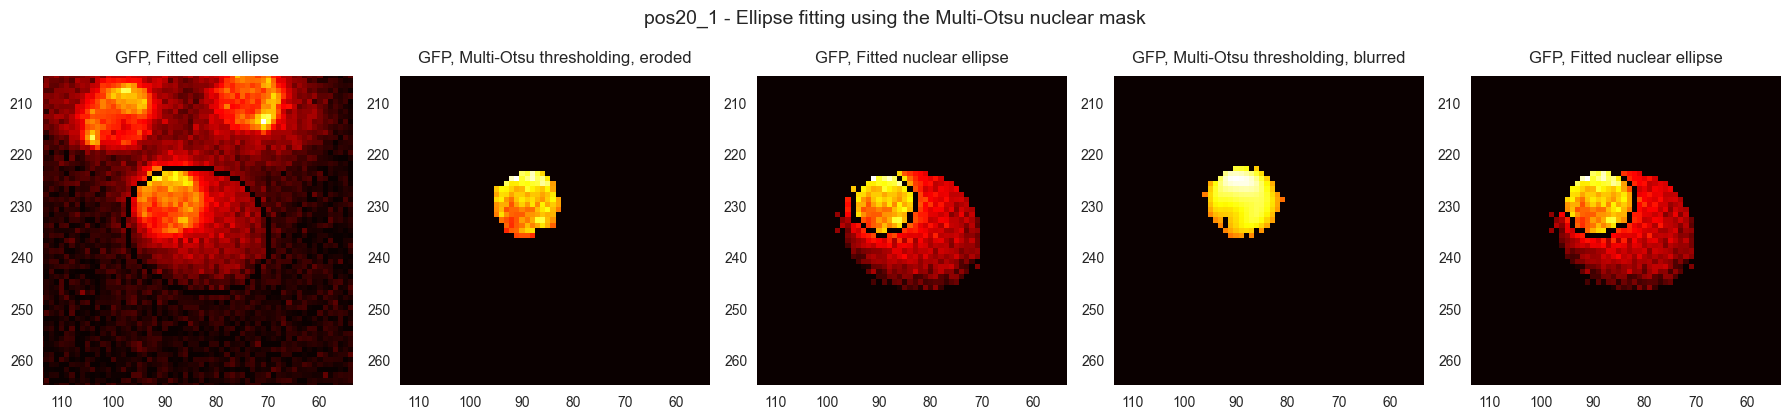

In [45]:
# TODO Only for the last processed cell above
# get the nuclear ellipse
(x, y), (MA, ma), angle = get_ellipse(imageGFP, imageGFP_nuc_mask_mlti_otsu_eroded)  # use imageRFP and nuc_mask_otsu from last plotted cell above
cv2_ellipse_mo_regular = ((x, y), (MA, ma), angle)
(x, y), (MA, ma), angle = get_ellipse(imageGFP, imageGFP_nuc_mask_mlti_otsu_eroded_blurred)  # use imageRFP and nuc_mask_otsu from last plotted cell above
cv2_ellipse_mo_blurred = ((x, y), (MA, ma), angle)

(c_x, c_y), (c_MA, c_ma), c_angle = get_ellipse(imageGFP, whole_cell_mask)
cv2_ellipse_cell = ((c_x, c_y), (c_MA, c_ma), c_angle)

# plot side by side
to_plot = [
    ["GFP, Fitted cell ellipse", cv2.ellipse(imageGFP, cv2_ellipse_cell, (0, 0, 0), 1), "hot"], # arguments: 1, image data 2, fitted ellipse 3, color (BGR), 4, linewidth
    ["GFP, Multi-Otsu thresholding, eroded", imageGFP * imageGFP_nuc_mask_mlti_otsu_eroded, "hot"],
    ["GFP, Fitted nuclear ellipse", cv2.ellipse(imageGFP * whole_cell_mask, cv2_ellipse_mo_regular, (0, 0, 0), 1), "hot"],
    ["GFP, Multi-Otsu thresholding, eroded + blurred", imageGFP_blurred * imageGFP_nuc_mask_mlti_otsu_eroded_blurred, "hot"],
    ["GFP, Fitted nuclear ellipse", cv2.ellipse(imageGFP * whole_cell_mask, cv2_ellipse_mo_blurred, (0, 0, 0), 1), "hot"]
]
plot_from_list(f"{cell} - Ellipse fitting using the Multi-Otsu nuclear mask", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30), False)

#### Brightness & Contrast adjustments on Local thresholding

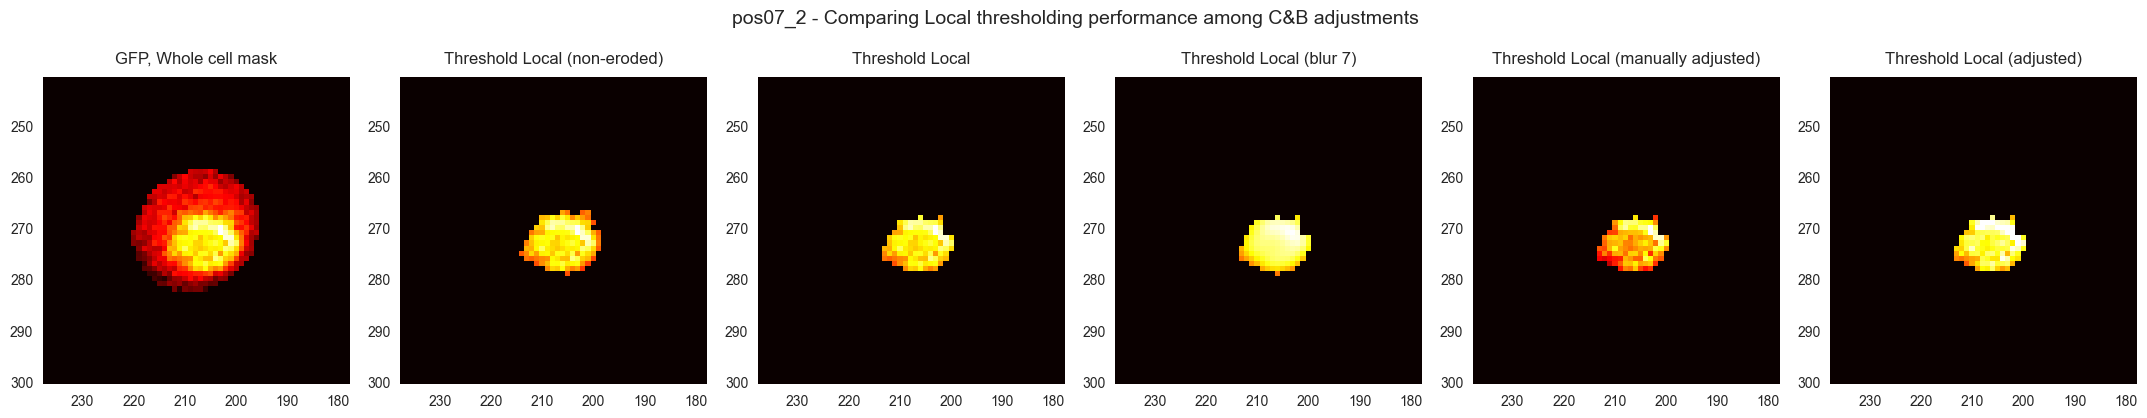

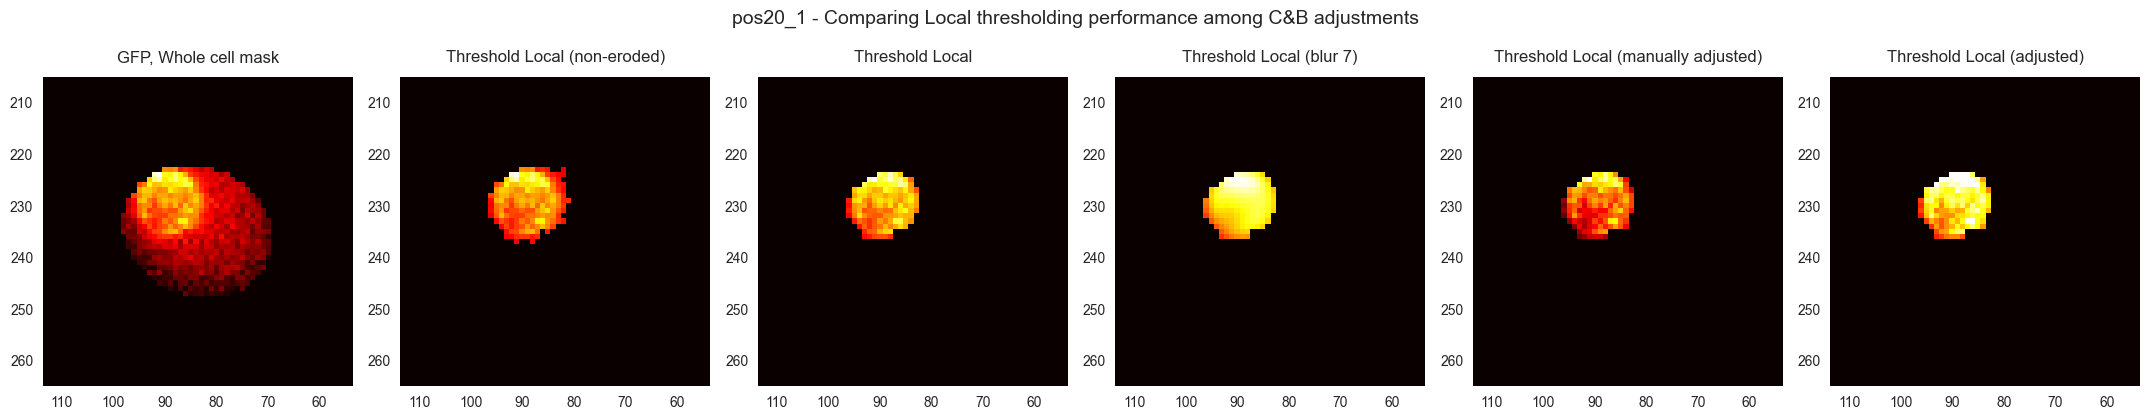

In [49]:
for cell in random_cells:
    pos = cell[3:5]

    image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif")) # load the image
    single_cell_data = budj_data[budj_data["Cell_pos"] == cell]  # get the data for the single cell

    # get the first available frame
    t = single_cell_data['TimeID'].iloc[0]
    t_in_tiff = t - 1

    imageBF = image[t_in_tiff, 0, :, :]
    imageGFP = image[t_in_tiff, 1, :, :]
    imageGFP_blurred = cv2.GaussianBlur(imageGFP,(7,7),0)
    new_imageGFP_adj = cv2.convertScaleAbs(imageGFP, alpha=a, beta=b)
    # manually adjust image
    new_image = np.zeros(imageGFP.shape, imageGFP.dtype)
    adj = 75
    for i in range(imageGFP.shape[0]):
        for j in range(imageGFP.shape[1]):
            prev_val = imageGFP[i, j]
            if prev_val >= adj:
                new_image[i, j] = prev_val - adj
            else:
                new_image[i, j] = 0

    whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP.shape)

                        # PERFORM DIFFERENT THRESHOLD METHODS
    num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
    bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

    # thresholding will be performed not on all image but on a fraction of it which includes the cell
    imageGFP_cell_mask = imageGFP * whole_cell_mask  # keep the part of the GFP channel that is within the cell mask
    imageGFP_blurred_cell_mask = imageGFP_blurred * whole_cell_mask
    adj_cell_mask = new_imageGFP_adj * whole_cell_mask
    man_adj_image_cell_mask = new_imageGFP_adj * whole_cell_mask

    # thresholding to get the nuclear mask
    nucl_thresh_mask_local = threshold_local(image=imageGFP_cell_mask, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)
    nucl_thresh_mask_local_blurred = threshold_local(image=imageGFP_blurred_cell_mask, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)
    nucl_thresh_mask_local_adj = threshold_local(image=adj_cell_mask, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)
    nucl_thresh_mask_local_man_adj = threshold_local(image=man_adj_image_cell_mask, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)

    # keep the pixels that are greater than the threshold
    imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
    imageGFP_nuc_mask_local_blurred = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local_blurred)
    imageGFP_nuc_mask_local_adj = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local_adj)
    imageGFP_nuc_mask_local_man_adj = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local_man_adj)

    # apply erosion
    imageGFP_nuc_mask_local_eroded = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))
    imageGFP_nuc_mask_local_eroded_blurred = binary_erosion(imageGFP_nuc_mask_local_blurred, structure = np.ones((2,2)))
    imageGFP_nuc_mask_local_eroded_adj = binary_erosion(imageGFP_nuc_mask_local_adj, structure = np.ones((2,2)))
    imageGFP_nuc_mask_local_eroded_man_adj = binary_erosion(imageGFP_nuc_mask_local_adj, structure = np.ones((2,2)))

    to_plot = [
        ["GFP, Whole cell mask",  imageGFP * whole_cell_mask, "hot"],
        ["Threshold Local (non-eroded)", imageGFP * imageGFP_nuc_mask_local, "hot"],
        ["Threshold Local", imageGFP * imageGFP_nuc_mask_local_eroded, "hot"],
        ["Threshold Local (blur 7)", imageGFP_blurred * imageGFP_nuc_mask_local_eroded_blurred, "hot"],
        ["Threshold Local (manually adjusted)", new_image * imageGFP_nuc_mask_local_eroded_man_adj, "hot"],
        ["Threshold Local (adjusted)", new_imageGFP_adj * imageGFP_nuc_mask_local_eroded_adj, "hot"]
    ]

    plot_from_list(f"{cell} - Comparing Local thresholding performance among C&B adjustments", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30))

#### Fitting the nuclear ellipse
Using the get_ellipse function, we now plot the original RFP channel, the thresholding result, and the fitted ellipse all in one figure to provide an overview of the performance.

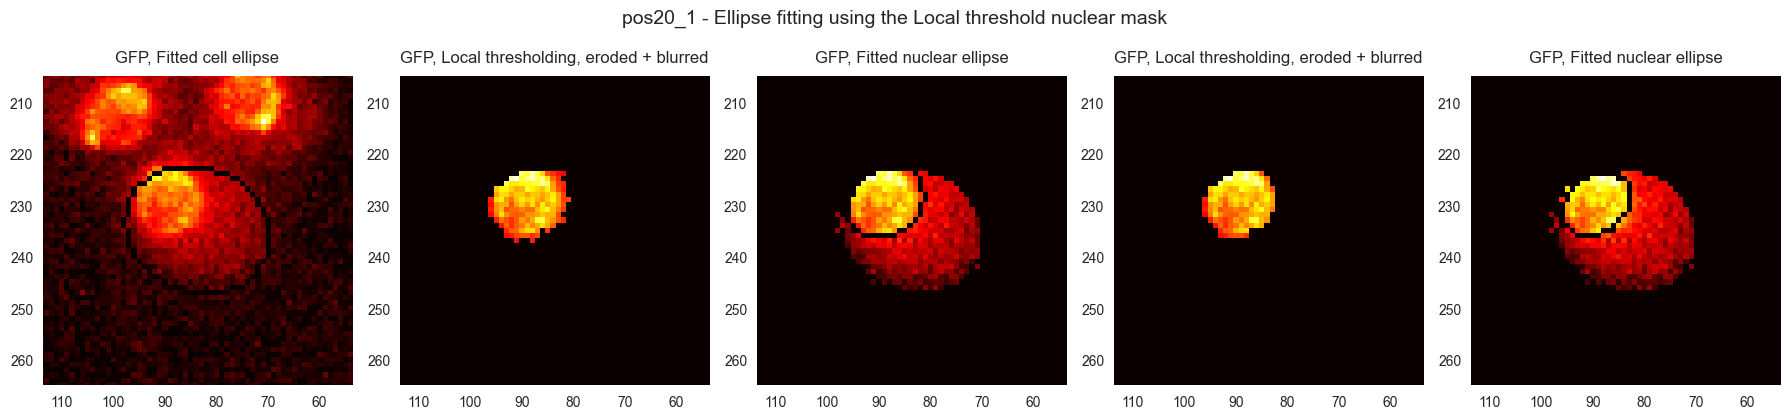

The major and minor axes of the ellipse are 14.39962387084961 and 11.23453140258789, respectively.


In [50]:
# TODO Only for the last processed cell above
# get the nuclear ellipse
(x, y), (MA, ma), angle = get_ellipse(imageGFP, imageGFP_nuc_mask_local)
cv2_ellipse_regular = ((x, y), (MA, ma), angle)
(x, y), (MA, ma), angle = get_ellipse(imageGFP, imageGFP_nuc_mask_local_eroded_blurred)
cv2_ellipse_lt = ((x, y), (MA, ma), angle)

(c_x, c_y), (c_MA, c_ma), c_angle = get_ellipse(imageGFP, whole_cell_mask)
cv2_ellipse_cell = ((c_x, c_y), (c_MA, c_ma), c_angle)

# plot side by side
to_plot = [
    ["GFP, Fitted cell ellipse", cv2.ellipse(imageGFP, cv2_ellipse_cell, (0, 0, 0), 1), "hot"], # arguments: 1, image data 2, fitted ellipse 3, color (BGR), 4, linewidth
    ["GFP, Local thresholding, eroded + blurred", imageGFP * imageGFP_nuc_mask_local, "hot"],
    ["GFP, Fitted nuclear ellipse", cv2.ellipse(imageGFP * whole_cell_mask, cv2_ellipse_regular, (0, 0, 0), 1), "hot"],
    ["GFP, Local thresholding, eroded + blurred", imageGFP * imageGFP_nuc_mask_local_eroded_blurred, "hot"],
    ["GFP, Fitted nuclear ellipse", cv2.ellipse(imageGFP * whole_cell_mask, cv2_ellipse_lt, (0, 0, 0), 1), "hot"]
]
plot_from_list(f"{cell} - Ellipse fitting using the Local threshold nuclear mask", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30), False)

print(f"The major and minor axes of the ellipse are {ma} and {MA}, respectively.")

### Ellipse fitting performance over time
To get an insight in how well our nuclear thresholding approach performs, the following code block generates the fitted nuclear ellipse for all timepoints for all cells. The figures are saved to the Data/Output/ellipse_overviews folder.
To do this for only a few positions, change 'range(1,21)' to something like: \[4, 15]. In that case, figures will only be generated for the cells in positions 4 and 15, and the runtime is significantly shorter.

In [197]:
for pos in range(1,21):
    if pos < 10:
        pos = "0"+ str(pos)
    image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif")) # load the image
    imageGFP = image[:, 1, :, :] # get the GFP data

    for cell in individual_cells:
        if 'pos'+str(pos) in cell:
            ellipses = []
            could_not_fit = 0
            single_cell_data = budj_data[budj_data["Cell_pos"] == cell]  # pick only the data of the first cell

            for t in single_cell_data.TimeID:
                # skew the time by one for tiff dataframe
                t_in_tiff = t - 1

                imageGFP_at_frame = imageGFP[t_in_tiff, :, :] # get the GFP data
                # imageGFP_adj = cv2.convertScaleAbs(imageGFP_at_frame, alpha=1.4, beta=-150)
                # imageGFP_blurred = cv2.GaussianBlur(imageGFP_at_frame,(7,7),0) # blurred GFP data

                whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP_at_frame.shape)  # get the cell mask
                imageGFP_cell_mask = imageGFP_at_frame * whole_cell_mask  # keep the part of the RFP channel that is within the cell mask
                # imageGFP_adj_cell_mask = imageGFP_adj * whole_cell_mask  # keep the part of the RFP channel that is within the cell mask
                # imageGFP_blurred_cell_mask = imageGFP_blurred * whole_cell_mask  # blurred cell mask for local thresholding

                num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
                bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

                nuc_thresh_mask_local = threshold_local(image=imageGFP_cell_mask, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)
                # adj_nuc_thresh_mask_local = threshold_local(image=imageGFP_adj_cell_mask, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)
                # nuc_thresh_mask_local_blurred = threshold_local(image=imageGFP_blurred_cell_mask, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)
                imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nuc_thresh_mask_local)
                # imageGFP_adj_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > adj_nuc_thresh_mask_local)
                # imageGFP_nuc_mask_local_blurred = remove_small_objects(imageGFP_cell_mask > nuc_thresh_mask_local_blurred)
                imageGFP_nuc_mask_local_eroded = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))
                # imageGFP_nuc_mask_local_eroded = cv2.erode(nuc_thresh_mask_local, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations=1)
                # imageGFP_nuc_mask_local_eroded_blurred = binary_erosion(imageGFP_nuc_mask_local_blurred, structure = np.ones((2,2)))

                try:
                    (x, y), (MA, ma), angle = get_ellipse(imageGFP_at_frame, imageGFP_nuc_mask_local_eroded)
                    # cv2_ellipse = ((x, y), (MA, ma), angle)
                except TypeError:
                    could_not_fit += 1
                    continue

                # also fit an ellipse on the whole cell mask
                (c_x, c_y), (c_MA, c_ma), c_angle = get_ellipse(imageGFP_at_frame, whole_cell_mask)

                r1c = (c_MA * scaling_factor) # to get the semi-major axis
                r2c = (c_ma * scaling_factor) # to get the semi-minor axis
                r3c = (np.average((c_MA, c_ma)) * scaling_factor) # to get the third axis (average of two known axes)
                cell_volume = (4/3) * pi * r1c * r2c * r3c

                r1n = (MA * scaling_factor) # to get the semi-major axis
                r2n = (ma * scaling_factor) # to get the semi-minor axis
                r3n = (np.average((MA, ma)) * scaling_factor) # to get the third axis (average of two known axes)
                nuc_volume = (4/3) * pi * r1n * r2n * r3n
                # save the fitted ellipse for this time-point to a list
                ellipses.append((t, x_pos, y_pos, cv2.ellipse(imageGFP_at_frame * whole_cell_mask, ((x, y), (MA, ma), angle), (0, 0, 0), 1), cell_volume, nuc_volume))

            print(f"{cell} - Couldn't fit ellipse {could_not_fit} out of {len(single_cell_data['TimeID'])} times")
            plt.ioff()
            fig = plt.figure(
                figsize=(35, 25),
                edgecolor="black",
                frameon=True,
                facecolor="white",
                layout="tight"
            ).suptitle(f"Cell {cell} - Fitted ellipses over time", fontsize=14, y=0.99)
            subplot_num = 1
            for ellipse in ellipses:
                t = ellipse[0]
                cell_vol = ellipse[4]
                nuc_vol = ellipse[5]
                subplt = plt.subplot(10, 15, subplot_num)
                subplt.set_title(label=f"t = {t}, N/C ratio = {round(nuc_vol / cell_vol, 4)}", y=1.02)
                plt.imshow(ellipse[3], cmap="hot")
                subplt.grid(False)
                plt.xlim(ellipse[1] + 30, ellipse[1] - 30)
                plt.ylim(ellipse[2] + 30, ellipse[2] - 30)
                subplot_num += 1
            plt.savefig(f"{output_dir}ellipse_overviews/eroded_cv2/{cell}_ellipse_over_time_threshold_local_eroded.png", dpi=500)
            plt.close()

pos01_1 - Couldn't fit ellipse 13 out of 71 times
pos01_2 - Couldn't fit ellipse 0 out of 69 times
pos02_1 - Couldn't fit ellipse 0 out of 74 times
pos02_2 - Couldn't fit ellipse 2 out of 67 times
pos02_3 - Couldn't fit ellipse 2 out of 80 times
pos03_1 - Couldn't fit ellipse 1 out of 95 times
pos03_2 - Couldn't fit ellipse 1 out of 60 times
pos03_3 - Couldn't fit ellipse 0 out of 80 times
pos04_1 - Couldn't fit ellipse 0 out of 80 times
pos04_2 - Couldn't fit ellipse 0 out of 83 times


KeyboardInterrupt: 

Ultimately, the performance of the following methods have been assessed through time-series ellipse fitting using the code-block above:
* Local thresholding (non-eroded)
* Local thresholding (eroded)
* Local thresholding (gaussian blur 5, non-eroded)
* Local thresholding (gaussian blur 5, eroded)
* Multi-Otsu thresholding (non-eroded)
* Multi-Otsu thresholding (eroded)

The conclusions of this comparison are that the erosion is a bit too aggressive, which results in the exclusion of pixels that are clearly, which you can tell by eye solely, part of the nucleus. This is true for all cases where erosion was applied. Furthermore, while Multi-Otsu thresholding seemed promising earlier on in this research, it is now deemed unfit to provide a consistent fit of the nucleus. This is because there are way to many frames for which it is unable to find the nucleus at all, resulting in the loss of a significant part of the datapoints, which is undesirable.
This leaves us with Local thresholding (non-eroded), non-blurred, or blurred (intensities 5 or 7). The result of the method where a more intense blur is applied (7), results in slight overestimation of the nuclear area in some frames, although this makes only a very slight difference in nuclear to cell ratios. The difference between blur (5) and regular non-eroded local thresholding is almost negligible. We're working with regular non-eroded local thresholding from here.
### Comparing the volume dynamics of multiple cells over time
#### Generate volume data over time for whole-cell and nucleus

To do this neatly, we perform the volume calculations for every frame for every cell, append these to the 'single_cell_data' dataframe, whereafter these are all concatenated into the final dataframe that contains the volume data over time for all cells.

In [198]:
# NOTE: If you have already generated this data, use this code chunk to load it from the excel file. This saves you some time.
final_dataframe = pd.read_excel(f"{output_dir}excel/nup133_final_data.xlsx")

In [78]:
final_dataframe = pd.DataFrame({})

for pos in range(1,21):
    if pos < 10:
        pos = "0"+ str(pos)
    image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif")) # load the image
    imageGFP = image[:, 1, :, :] # get the GFP data

    for cell in individual_cells:
        if 'pos'+str(pos) in cell:
            could_not_fit = 0

            single_cell_data = budj_data[budj_data["Cell_pos"] == cell]  # get the data for the single cell
            single_cell_data = single_cell_data.sort_values(by="Time")

            cell_volumes = []
            nuc_volumes = []
            for t in single_cell_data.TimeID:
                t_in_tiff = t - 1  # skew the time by one for tiff dataframe
                imageGFP_at_frame = imageGFP[t_in_tiff, :, :] # get the GFP data

                whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP_at_frame.shape)  # get the cell mask through budj data
                imageGFP_cell_mask = imageGFP_at_frame * whole_cell_mask  # keep the part of the image info that is within the cell mask

                num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
                bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

                nucl_thresh_mask_local = threshold_local(image=imageGFP_cell_mask, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)
                imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
                # ellipse fitting!
                (c_x, c_y), (c_MA, c_ma), c_angle = get_ellipse(imageGFP_at_frame, whole_cell_mask)  # fit an ellipse on the whole cell mask

                r1c = (c_MA * scaling_factor) # to get the semi-major axis of the whole cell
                r2c = (c_ma * scaling_factor) # to get the semi-minor axis of the whole cell
                r3c = (np.average((c_MA, c_ma)) * scaling_factor) # to get the third axis
                cell_volume = (4/3) * pi * r1c * r2c * r3c

                cell_volumes.append(cell_volume)  # append cell volume for this time-point to list holding cell volumes for all timepoints

                # try to fit the ellipse on the nucleus, if there is none, then add None to the list
                try:
                    (x, y), (MA, ma), angle = get_ellipse(imageGFP_at_frame, imageGFP_nuc_mask_local)
                    cv2_ellipse = ((x, y), (MA, ma), angle)
                except Exception:
                    # thresholding did not lead to an ellipse, nucleus was probably out of focus
                    could_not_fit += 1
                    nuc_volumes.append(None)
                    continue

                r1n = (MA * scaling_factor) # to get the semi-major axis of the nucleus
                r2n = (ma * scaling_factor) # to get the semi-minor axis of the nucleus
                r3n = (np.average((MA, ma)) * scaling_factor) # to get the third axis
                nuc_volume = (4/3) * pi * r1n * r2n * r3n

                # append nuclear volume for this time-point to list holding nuclear volumes for all timepoints
                nuc_volumes.append(nuc_volume)

            # calculate the ratios
            ratios = []
            i = 0
            for nuc_vol in nuc_volumes:
                if nuc_vol is None:
                    ratios.append(None)
                else:
                    ratios.append(nuc_vol / cell_volumes[i])

            # store data in this cell its dataframe
            single_cell_data["Cell_volume"] = pd.Series(cell_volumes, index=single_cell_data.index)
            single_cell_data["Nucleus_volume"] = pd.Series(nuc_volumes, index=single_cell_data.index)
            single_cell_data["N/C_ratio"] = pd.Series(ratios, index=single_cell_data.index)

            # store this cell's data in the final dataframe which eventually contains data of all cells
            final_dataframe = pd.concat([final_dataframe, single_cell_data])

            print(f"{cell} - Couldn't fit ellipse {could_not_fit} out of {len(single_cell_data['TimeID'])} times")

final_dataframe = final_dataframe.reset_index(drop="true")  # reset index of dataframe
final_dataframe.to_excel(f"{output_dir}excel/nup133_final_data.xlsx")  # save the final file

pos01_1 - Couldn't fit ellipse 13 out of 71 times
pos01_2 - Couldn't fit ellipse 0 out of 69 times
pos02_1 - Couldn't fit ellipse 0 out of 74 times
pos02_2 - Couldn't fit ellipse 2 out of 67 times
pos02_3 - Couldn't fit ellipse 2 out of 80 times
pos03_1 - Couldn't fit ellipse 1 out of 95 times
pos03_2 - Couldn't fit ellipse 1 out of 60 times
pos03_3 - Couldn't fit ellipse 0 out of 80 times
pos04_1 - Couldn't fit ellipse 0 out of 80 times
pos04_2 - Couldn't fit ellipse 0 out of 83 times
pos05_1 - Couldn't fit ellipse 2 out of 95 times
pos05_2 - Couldn't fit ellipse 0 out of 68 times
pos06_1 - Couldn't fit ellipse 0 out of 90 times
pos06_2 - Couldn't fit ellipse 5 out of 68 times
pos07_1 - Couldn't fit ellipse 0 out of 75 times
pos07_2 - Couldn't fit ellipse 2 out of 90 times
pos07_3 - Couldn't fit ellipse 1 out of 82 times
pos07_4 - Couldn't fit ellipse 1 out of 80 times
pos08_1 - Couldn't fit ellipse 1 out of 76 times
pos08_2 - Couldn't fit ellipse 2 out of 80 times
pos08_3 - Couldn't 

### Plotting the volumes
Now plot the nuclear and whole cell volumes in one figure and save this instead of plotting it here.

In [102]:
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20, 30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
fig.suptitle("Nuclear and whole-cell volumes over time", fontsize=16, y=0.905)

count = 0
for i in range(10):
    for j in range(5):
        if count < len(individual_cells):
            cell = individual_cells[count]
            single_cell_data = final_dataframe[final_dataframe.Cell_pos == cell]
            single_cell_data = single_cell_data[~single_cell_data.Nucleus_volume.isnull()]  # remove all instances where nuclear volume is unknown

            ax[i,j].plot(single_cell_data.TimeID, single_cell_data.Cell_volume)
            ax[i,j].plot(single_cell_data.TimeID, single_cell_data.Nucleus_volume)
            ax[i,j].set_title(f"{cell}", fontstyle='italic', y=1.02)
            count += 1

plt.savefig(output_dir + "volumes_overT_together_local_non_eroded.png", bbox_inches='tight', dpi=350)
plt.close(fig)

If desired, the below chunk can be used to plot the nuclear and whole cell volumes of the cells in separate figures, instead of all in one.

In [59]:
plt.ioff()
count = 0
for cell in individual_cells:
    fig, axs = plt.subplots(2, figsize=(5, 5))
    fig.subplots_adjust(hspace=0.35, wspace=0.4)
    fig.suptitle(f"{cell} - Whole cell and nuclear volumes over time")
    single_cell_data = final_dataframe[final_dataframe.Cell_pos == cell]
    single_cell_data = single_cell_data[~single_cell_data.Nucleus_volume.isnull()]  # remove all instances where nuclear volume is unknown

    axs[0].plot(single_cell_data.TimeID, single_cell_data.Cell_volume, 'r')
    axs[0].set_title("Whole cell volume", fontstyle='italic', y=1.02)
    axs[1].plot(single_cell_data.TimeID, single_cell_data.Nucleus_volume, 'y')
    axs[1].set_title("Nuclear volume", fontstyle='italic', y=1.02)
    plt.savefig(output_dir + "separate_cell_plots/" + f"{cell}_volumes_overT.png", bbox_inches='tight', dpi=200)
    plt.close(fig)
    count += 1

### Plotting the N/C ratios
Nuclear to whole-cell ratios

In [67]:
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20, 30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
fig.suptitle("Nuclear/whole-cell ratios over time", fontsize=16, y=0.905)

count = 0
for i in range(10):
    for j in range(5):
        if count < len(individual_cells):
            cell = individual_cells[count]
            single_cell_data = final_dataframe[final_dataframe.Cell_pos == cell]
            single_cell_data = single_cell_data[~single_cell_data.Nucleus_volume.isnull()]  # remove all instances where nuclear volume is unknown
            ratios = [nuc_vol/cell_vol for nuc_vol,cell_vol in zip(single_cell_data.Nucleus_volume, single_cell_data.Cell_volume)]

            ax[i,j].plot(ratios)
            ax[i,j].set_title(f"{cell}", fontstyle='italic', y=1.02)
            count += 1

plt.savefig(output_dir + "nuc_to_cell_ratios_local_min_3rd_axis.png", bbox_inches='tight', dpi=350)
plt.close(fig)

### Filtering out the outliers
Removal of datapoints where the nuclear to cell ratio is too high to be correct.

In [199]:
final_dataframe = final_dataframe.drop(final_dataframe[final_dataframe["N/C_ratio"] > .32].index)
final_dataframe = final_dataframe.reset_index(drop="true")  # reset index of dataframe
final_dataframe.to_excel(f"{output_dir}excel/nup133_final_data_removed_outliers.xlsx")  # save the final file

### Splitting on cell cycles and perform interpolation

In [201]:
desired_datapoints = 100
cols = ["cell", "cycle", "start", "end"]
cols += range(desired_datapoints)
data_interpolated = pd.DataFrame(columns=cols)

for cell in individual_cells[1:]:  # remove cell pos01_1, since it has too many missing frames
    single_cell_data = final_dataframe[final_dataframe.Cell_pos == cell]
    single_cell_data = single_cell_data[~single_cell_data.Nucleus_volume.isnull()]

    # print(f"Kario events for {cell}: {kario_events[cell]}")
    count = 0
    while count < len(kario_events[cell]) - 1:
        tp1 = kario_events[cell][count]
        tp2 = kario_events[cell][count + 1]
        # print(f"{cell} - Getting N/C ratio data from {tp1} through {tp2}")
        cell_cycle_dat = single_cell_data[single_cell_data.TimeID.between(tp1, tp2)]

        # when there are not enough datapoints for this cycle, because of outlier cleaning, then ignore that cycle
        if len(cell_cycle_dat) < 10:
            count += 1
            continue

        # get the original x and y data
        x = np.linspace(0, len(cell_cycle_dat), len(cell_cycle_dat))
        y = cell_cycle_dat['N/C_ratio']

        # interpolate the data towards 100 datapoints
        x_new = np.linspace(0, len(cell_cycle_dat), 100)
        f1 = interpolate.interp1d(x, y, kind='linear')
        f2 = interpolate.interp1d(x, y, kind='cubic')

        # add the interpolated data to a dataframe
        data_interpolated.loc[len(data_interpolated)] = [cell, count + 1, tp1, tp2] + f2(x_new).tolist()
        count += 1

data_interpolated.to_excel(f"{output_dir}excel/cycles_interpolated_removed_outliers.xlsx")  # save the final file

#### Save a plot for every interpolated cycle

In [190]:
plt.ioff()
count = 0
while count < len(data_interpolated):
    single_cycle_data = data_interpolated.iloc[count]
    plt.plot(single_cycle_data[4:].values, 'r', linewidth=3)
    cell_name = single_cycle_data['cell']
    cycle_id = single_cycle_data['cycle']
    plt.title(f"{cell_name}, cycle {cycle_id}", fontstyle='italic', y=1.02)
    plt.xlabel("Time")
    plt.ylabel("N/C Ratio")
    plt.savefig(f"{output_dir}separate_cell_plots/interpolated_cycles/removed_outliers/{cell_name}_cycle{cycle_id}_interpolated.png", bbox_inches='tight', dpi=350)
    plt.close()
    count += 1